In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import aesara.tensor as at

In [2]:
az.style.use('arviz-darkgrid')

# Gaussian Mixture model

In [3]:
n = 20

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
logdsigma = np.linalg.slogdet(sigma)[1]

w1 = 0.1
w2 = (1 - w1)

In [4]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * at.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * at.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return pm.math.logsumexp([at.log(w1) + log_like1, at.log(w2) + log_like2])

In [5]:
with pm.Model() as model:
    X = pm.Uniform('X',
                   shape=n,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   testval=-1. * np.ones_like(mu1))
    llk = pm.Potential('llk', two_gaussians(X))

/Users/ciguaran/personal/pymc/pymc/distributions/continuous.py:167: FutureWarning: The `testval` argument is deprecated; use `initval`.
  return super().__new__(cls, *args, **kwargs)


In [6]:
with model:
    idata_nuts = pm.sample(5000, cores=1)

Sequential sampling (2 chains in 1 job)
NUTS: [X]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
with model:
    idata_smc = pm.sample_smc(5000, cores=1, progressbar=True) 

Initializing SMC sampler...
Sampling 2 chains in 1 job


/Users/ciguaran/personal/pymc/pymc/smc/smc.py:180: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  result = sample_prior_predictive(


Resample (0.001495679219563802, 0.00027284763119075217)
Mutate (1.7970200777053833, 0.6387070676548534)
Update (0.0025728543599446616, 0.0008543445490303222)
Stages 18
Total time 33.81903791427612


/Users/ciguaran/personal/pymc/pymc/smc/smc.py:180: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  result = sample_prior_predictive(
We recommend running at least 4 chains for robust computation of convergence diagnostics


Resample (0.0018048153983222113, 0.0006280749578543129)
Mutate (2.037397119734022, 0.5381935253843877)
Update (0.003506779670715332, 0.0024485304658227246)
Stages 18
Total time 38.07314682006836


In [9]:
with model:
    idata_smc_hmc_1 = pm.sample_smc(5000, kernel=pm.smc.HMC, 
                                            n_steps=None,
                                            path_length=50,
                                            max_steps=3,
                                            vars=None,
                                            cores=1,
                                            chains=2)

Initializing SMC sampler...
Sampling 2 chains in 1 job


/Users/ciguaran/personal/pymc/pymc/smc/smc.py:180: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  result = sample_prior_predictive(
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_s

Resample (0.003921156344206437, 0.0010309236498070695)
Mutate (5.8802917107291846, 2.411272983400527)
Update (2.572908183802729, 0.6540606527329613)
Compile (2.4792770942052207, 0.7471410467833156)
One particle iteration (0.001112416290200275, 0.0016264714206415318)
Stages 23
Total time 318.7083089351654


/Users/ciguaran/personal/pymc/pymc/smc/smc.py:180: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  result = sample_prior_predictive(
We recommend running at least 4 chains for robust computation of convergence diagnostics


Resample (0.002420696345242587, 0.0005469737077973366)
Mutate (2.5937907045537774, 0.15610697333493806)
Update (1.5165804407813332, 0.38261565115037927)
Compile (1.5133488903874937, 0.37465870606794743)
One particle iteration (0.00048682813427665015, 0.00017846550722322349)
Stages 22
Total time 281.1660590171814


In [10]:
def results(idata):
    ax = az.plot_trace(idata, compact=True, kind="rank_vlines")
    ax[0, 0].axvline(-0.5, 0, .9, color="k")
    ax[0, 0].axvline(0.5, 0, 0.1, color="k")
    ax[0, 0].set_xlim(-1, 1)
    np.mean(idata.posterior["X"] > 0).item()

In [ ]:
results(idata_nuts)

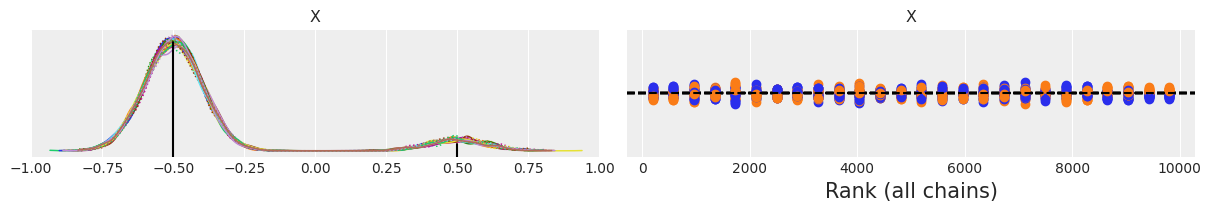

In [11]:
results(idata_smc)

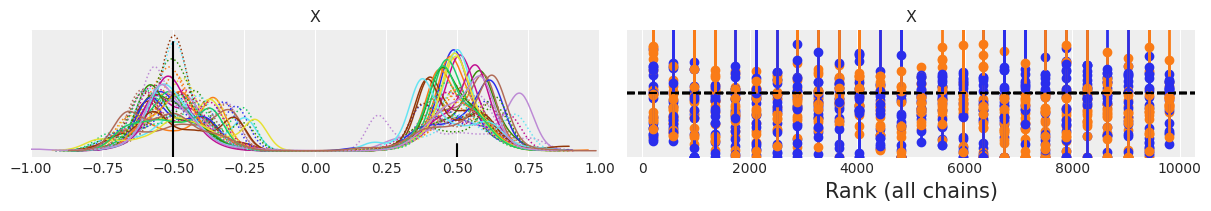

In [12]:
results(idata_smc_hmc_1)

# Increasing number of steps length

In [13]:
with model:
    idata_smc_hmc_2 = pm.sample_smc(5000, kernel=pm.smc.HMC, 
                                  n_steps=None,
                                  path_length=50,
                                  max_steps=5,
                                  vars=None,
                                  cores=1,
                                  chains=4)

Initializing SMC sampler...
Sampling 4 chains in 1 job


/Users/ciguaran/personal/pymc/pymc/smc/smc.py:180: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  result = sample_prior_predictive(
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Resample (0.002477906999133882, 0.0005561272144253794)
Mutate (3.8495535396394276, 0.24634835407368366)
Update (1.7024327232724143, 0.32558911206761765)
Compile (1.6441231532530352, 0.39393753832378225)
One particle iteration (0.0007363836220332555, 0.0003012831384170848)
Stages 21
Total time 241.99260807037354
Resample (0.0022951147773049092, 0.0006453633408965287)
Mutate (3.8339855562556875, 0.34696791463288185)
Update (1.6930493983355435, 0.329148227173003)
Compile (1.6382427733877432, 0.3909408468102361)
One particle iteration (0.0007333358569578691, 0.00036508469093890917)
Stages 22
Total time 238.9292869567871
Resample (0.002516107125715776, 0.00044976650228913736)
Mutate (4.6508508053692905, 1.3738149414064893)
Update (1.9913421435789629, 0.43633472880318686)
Compile (1.921818556992904, 0.5142241845357589)
One particle iteration (0.0008937180215662176, 0.0010514398838146885)
Stages 22
Total time 273.71714091300964
Resample (0.002481774850325151, 0.0006688684771914658)
Mutate (4.

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Compute error score

In [14]:
def compute_error_score(idata):
    # Wang bimodality index True Value
    BI = abs(mu1 - mu2) * (w1*(1-w1))**0.5
    posterior = idata.posterior
    error_score_list = []

    for chain in posterior["chain"]:
        for dimension in posterior["X_dim_0"]:
            v = np.ravel(posterior.isel(chain=chain, X_dim_0=dimension)["X"])
            above_zero = v > 0
            below_zero = v < 0
            w1_ = np.mean(below_zero)
            if np.any(above_zero) and np.any(below_zero):
                BI_ = abs(v[below_zero].mean() - v[above_zero].mean()) * (w1_*(1-w1_))**0.5
            else:
                BI_ = 0
            error_score = (np.mean(((v-mu1[0]) * w1 + (v-mu2[0]) * w2))**2)**0.5 + abs(BI - BI_)
            error_score_list.append(error_score)

    np.mean(error_score_list), np.std(error_score_list)

# Hierarchical Model

For this model we may use NUTS as a "gold-standard"

In [15]:
data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)
n_counties = len(data.county.unique())

In [16]:
with pm.Model() as hierarchical_model_non_centered:
    mu_a = pm.Normal('mu_a', mu=0., sd=5)
    sigma_a = pm.HalfNormal('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=5)
    sigma_b = pm.HalfNormal('sigma_b', 5)
     
    a_offset = pm.Normal('a_offset', mu=0, sd=2, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    b_offset = pm.Normal('b_offset', mu=0, sd=2, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
 
    eps = pm.HalfNormal('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [32]:
with hierarchical_model_non_centered:
    idata_nuts_hierarchical = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a_offset, b_offset, eps]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 107 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


In [33]:
with hierarchical_model_non_centered:
    idata_smc_hierarchical = pm.sample_smc(5000, cores=1)

Initializing SMC sampler...
Sampling 2 chains in 1 job


Resample (0.0027759725397283382, 0.00031169618897646125)
Mutate (2.1895929900082676, 0.28690461477396173)
Update (0.0023896477439186788, 0.0005825549488826424)
Stages 22
Total time 53.432289838790894
Resample (0.0027350964753524117, 0.0008308037517911436)
Mutate (2.00044554212819, 0.15037344184341583)
Update (0.0023617848106052565, 0.0005482099761921969)
Stages 23
Total time 52.266854763031006


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [34]:
with hierarchical_model_non_centered:
    idata_smc_hmc_hierarchical = pm.sample_smc(5000, kernel=pm.smc.HMC,
                                       n_steps=4,
                                       path_length=10,
                                       max_steps=3,
                                       vars=None,
                                       cores=1,
                                       progressbar=True)

Initializing SMC sampler...
Sampling 2 chains in 1 job


/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Resample (0.004705077723452919, 0.0022941695306859544)
Mutate (6.381312495783756, 0.5299208526395739)
Update (2.2265123819050037, 0.6998421325225199)
Compile (2.1641487956047056, 0.7219770564442064)
One particle iteration (0.0012115458990398205, 0.00046344808474613533)
Stages 19
Total time 377.25280499458313
Resample (0.0047809812757704, 0.002430721833482943)
Mutate (5.89932468202379, 0.4445382998923607)
Update (2.3209517267015247, 0.7092451048760146)
Compile (2.24633210583737, 0.7464552033055014)
One particle iteration (0.0011172741810480753, 0.00034741749949377955)
Stages 18
Total time 352.8741149902344


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [29]:
with hierarchical_model_non_centered:
    idata_smc_hmc_hierarchical_2 = pm.sample_smc(5000, kernel=pm.smc.HMC,
                                       n_steps=4,
                                       path_length=15,
                                       max_steps=3,
                                       vars=None,
                                       cores=1,
                                       progressbar=True)

Initializing SMC sampler...
Sampling 2 chains in 1 job


Resample (0.0019940081096830823, 0.0009102706794362639)
Mutate (2.7637340227762857, 0.36053737332427244)
Update (2.072005203792027, 0.569821310088684)
Compile (2.02055701342496, 0.5967216792036962)
One particle iteration (0.0013119828928084601, 0.0006373021588574386)
Stages 21
Total time 188.74875283241272
Resample (0.0021933317184448242, 0.0009597976664531351)
Mutate (2.650622682137923, 0.25398528227277367)
Update (2.2259286642074585, 0.5830411043613901)
Compile (2.167761937431667, 0.6240990686772241)
One particle iteration (0.0012595856514844028, 0.0005492511688448907)
Stages 22
Total time 194.59542512893677


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [37]:
with hierarchical_model_non_centered:
    idata_smc_hmc_hierarchical_3 = pm.sample_smc(5000, kernel=pm.smc.HMC,
                                       n_steps=4,
                                       path_length=30,
                                       max_steps=5,
                                       vars=None,
                                       cores=1,
                                       progressbar=True)

Initializing SMC sampler...
Sampling 2 chains in 1 job


/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Resample (0.00458934572007921, 0.0022862132878777902)
Mutate (8.001291513442993, 0.2664075965366056)
Update (2.319279339578417, 0.43799038040000976)
Compile (2.2433186832227205, 0.5144317497682173)
One particle iteration (0.0015399334695604112, 0.0004129386578047907)
Stages 18
Total time 387.25298714637756
Resample (0.004682064056396484, 0.002431391092213022)
Mutate (9.081345332296271, 1.2308701501475954)
Update (2.566054657885903, 0.5550549061852222)
Compile (2.477273416519165, 0.6451920794708141)
One particle iteration (0.0017507045043142217, 0.0007476556363349921)
Stages 19
Total time 415.9712791442871


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [38]:
with hierarchical_model_non_centered:
    idata_smc_hmc_hierarchical_4 = pm.sample_smc(5000, kernel=pm.smc.HMC,
                                       n_steps=4,
                                       path_length=60,
                                       max_steps=5,
                                       vars=None,
                                       cores=1,
                                       progressbar=True)

Initializing SMC sampler...
Sampling 2 chains in 1 job


/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Resample (0.005752444267272949, 0.00251505691245724)
Mutate (9.275533093346489, 0.6534174899124585)
Update (2.6579308244917126, 0.5726101174135766)
Compile (2.587460568076686, 0.6171891863660611)
One particle iteration (0.0017897802962197197, 0.0007635249085004566)
Stages 18
Total time 432.4440851211548
Resample (0.004861154054340564, 0.0029940921231377997)
Mutate (10.389048852418599, 1.2294551247586563)
Update (2.9824070930480957, 0.666592480737009)
Compile (2.928669834136963, 0.6780865712699428)
One particle iteration (0.002007189961483604, 0.001092685943718801)
Stages 19
Total time 463.7861771583557


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [46]:
with hierarchical_model_non_centered:
    idata_smc_hmc_hierarchical_5 = pm.sample_smc(5000, kernel=pm.smc.HMC,
                                       n_steps=4,
                                       path_length=200,
                                       max_steps=10,
                                       vars=None,
                                       cores=1,
                                       progressbar=True)

Initializing SMC sampler...
Sampling 2 chains in 1 job


/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Resample (0.005196734478599147, 0.002252994351752516)
Mutate (15.577794275785747, 1.206642392585683)
Update (2.726364248677304, 0.6693466842310973)
Compile (2.637952816486359, 0.7398509916131403)
One particle iteration (0.003047765295129073, 0.0013663344479896038)
Stages 19
Total time 561.0222868919373
Resample (0.006271110640631782, 0.004094308378453818)
Mutate (20.24834402402242, 2.20371734763639)
Update (3.5436481369866266, 0.9059653662431844)
Compile (3.3989180891137374, 1.0507203270333378)
One particle iteration (0.003972404061423408, 0.0019869899729848504)
Stages 18
Total time 644.6472859382629


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [55]:
with hierarchical_model_non_centered:
    idata_smc_hmc_hierarchical_6 = pm.sample_smc(50, kernel=pm.smc.HMC,
                                       n_steps=4,
                                       path_length=1000,
                                       max_steps=50,
                                       vars=None,
                                       cores=1,
                                       progressbar=True)

Initializing SMC sampler...
Sampling 2 chains in 1 job


/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


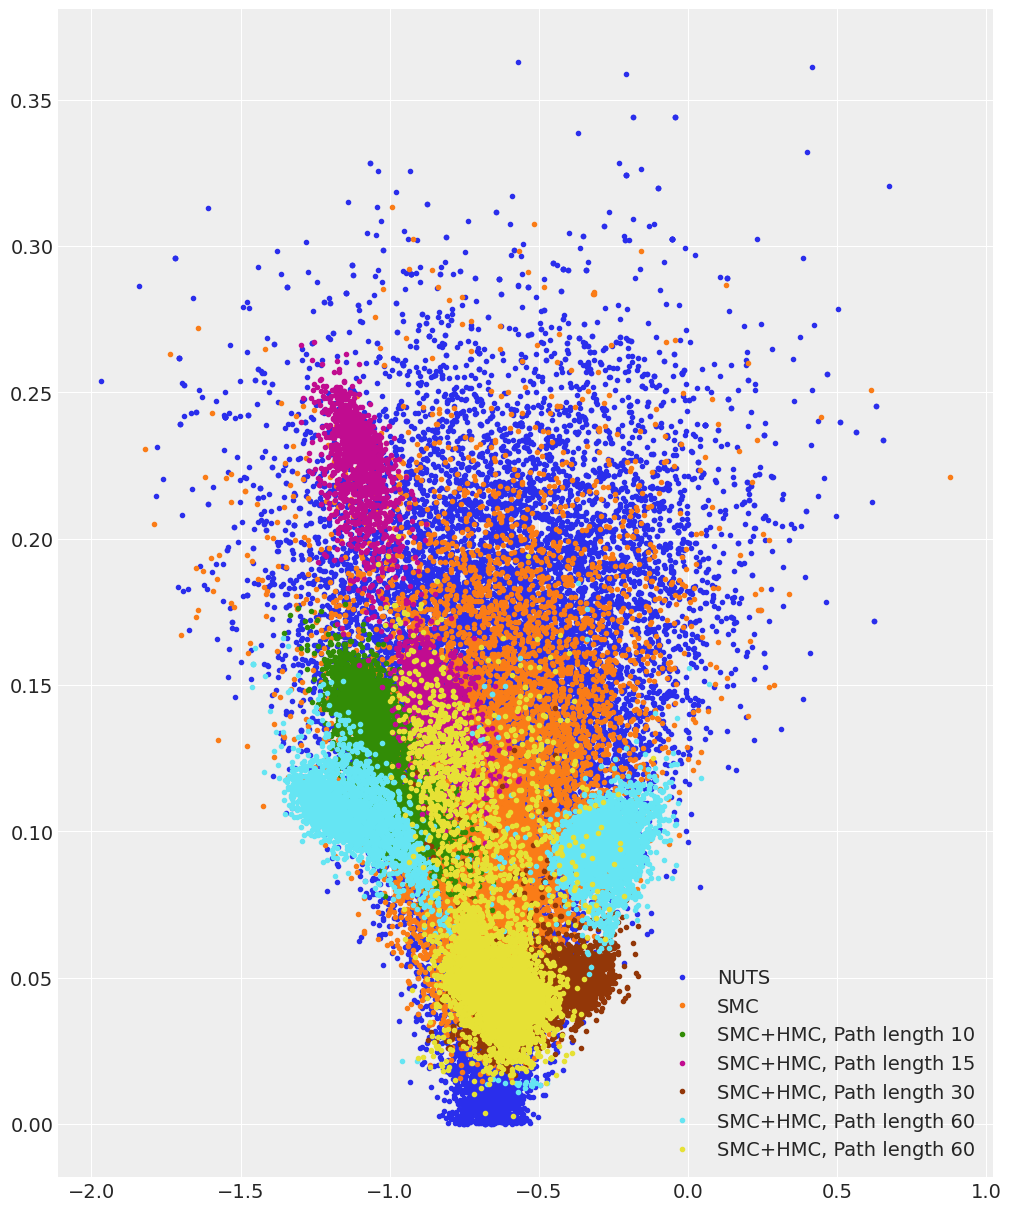

In [49]:
nuts_posterior = idata_nuts_hierarchical.posterior.stack(samples=("chain", "draw"))
smc_posterior = idata_smc_hierarchical.posterior.stack(samples=("chain", "draw"))
smc_hmc_posterior = idata_smc_hmc_hierarchical.posterior.stack(samples=("chain", "draw"))
smc_hmc_posterior_2 = idata_smc_hmc_hierarchical_2.posterior.stack(samples=("chain", "draw"))
smc_hmc_posterior_3 = idata_smc_hmc_hierarchical_3.posterior.stack(samples=("chain", "draw"))
smc_hmc_posterior_4 = idata_smc_hmc_hierarchical_4.posterior.stack(samples=("chain", "draw"))
smc_hmc_posterior_5 = idata_smc_hmc_hierarchical_5.posterior.stack(samples=("chain", "draw"))
plt.figure(figsize=(10,12))
plt.plot(nuts_posterior["b"].isel(b_dim_0=75), nuts_posterior["sigma_b"], '.C0', label="NUTS")
plt.plot(smc_posterior["b"].isel(b_dim_0=75), smc_posterior["sigma_b"], '.C1', label="SMC")
plt.plot(smc_hmc_posterior["b"].isel(b_dim_0=75), smc_hmc_posterior["sigma_b"], '.C2', label="SMC+HMC, Path length 10")
plt.plot(smc_hmc_posterior_2["b"].isel(b_dim_0=75), smc_hmc_posterior_2["sigma_b"], '.C3', label="SMC+HMC, Path length 15")
plt.plot(smc_hmc_posterior_3["b"].isel(b_dim_0=75), smc_hmc_posterior_3["sigma_b"], '.C4', label="SMC+HMC, Path length 30")
plt.plot(smc_hmc_posterior_4["b"].isel(b_dim_0=75), smc_hmc_posterior_4["sigma_b"], '.C5', label="SMC+HMC, Path length 60")
plt.plot(smc_hmc_posterior_5["b"].isel(b_dim_0=75), smc_hmc_posterior_5["sigma_b"], '.C6', label="SMC+HMC, Path length 60")
plt.legend()



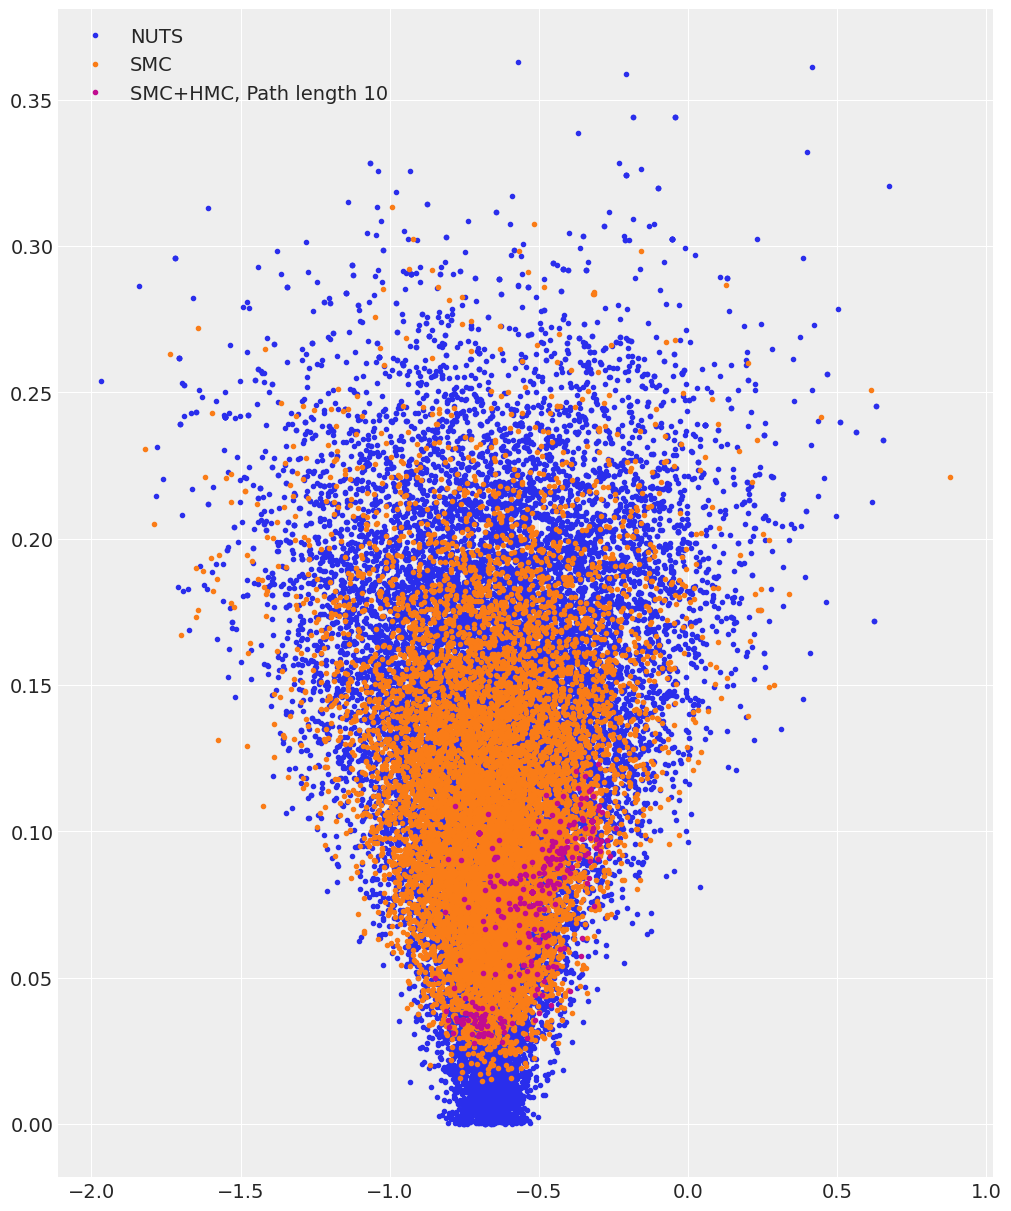

In [54]:
nuts_posterior = idata_nuts_hierarchical.posterior.stack(samples=("chain", "draw"))
smc_posterior = idata_smc_hierarchical.posterior.stack(samples=("chain", "draw"))
smc_hmc_posterior_6 = idata_smc_hmc_hierarchical_6.posterior.stack(samples=("chain", "draw"))
plt.figure(figsize=(10,12))
plt.plot(nuts_posterior["b"].isel(b_dim_0=75), nuts_posterior["sigma_b"], '.C0', label="NUTS")
plt.plot(smc_posterior["b"].isel(b_dim_0=75), smc_posterior["sigma_b"], '.C1', label="SMC")
plt.plot(smc_hmc_posterior_6["b"].isel(b_dim_0=75), smc_hmc_posterior_6["sigma_b"], '.C3', label="SMC+HMC, Path length 10")
plt.legend()

